In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hardfakevsrealfaces/data.csv
/kaggle/input/hardfakevsrealfaces/fake/fake_218.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_94.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_289.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_507.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_615.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_636.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_160.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_559.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_488.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_93.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_661.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_297.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_610.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_474.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_154.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_308.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_527.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_593.jpg
/kaggle/input/hardfakev

In [2]:
import os
import random
import shutil
import json
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

import warnings
warnings.filterwarnings('ignore')

from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50, MobileNetV2

import kagglehub
from collections import Counter

2025-12-22 00:05:15.578550: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766361915.762037      23 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766361915.813572      23 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766361916.264505      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766361916.264547      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766361916.264549      23 computation_placer.cc:177] computation placer alr

# 1- Dataset loading

In [3]:
# Download latest version
path = kagglehub.dataset_download("hamzaboulahia/hardfakevsrealfaces")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/hardfakevsrealfaces


In [4]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

fake_dir = os.path.join(path, "fake")
real_dir = os.path.join(path, "real")

image_ext = (".jpg", ".jpeg", ".png")

fake_images = [f for f in os.listdir(fake_dir) if f.endswith(image_ext)]
real_images = [f for f in os.listdir(real_dir) if f.endswith(image_ext)]

print("Fake images:", len(fake_images))
print("Real images:", len(real_images))
print("Total images:", len(fake_images) + len(real_images))

Fake images: 700
Real images: 589
Total images: 1289


# 2- Train / validation / test split

In [5]:
test_size = 0.2

fake_train, fake_test = train_test_split(fake_images, test_size=test_size, random_state=42)
real_train, real_test = train_test_split(real_images, test_size=test_size, random_state=42)

work_dir = "/kaggle/working/dataset_split"
for split in ["train", "test"]:
    for cls in ["fake", "real"]:
        os.makedirs(os.path.join(work_dir, split, cls), exist_ok=True)
def copy_images(files, src_dir, dst_dir):
    for f in files:
        shutil.copy2(os.path.join(src_dir, f), os.path.join(dst_dir, f))

copy_images(fake_train, fake_dir, os.path.join(work_dir, "train", "fake"))
copy_images(real_train, real_dir, os.path.join(work_dir, "train", "real"))

# Copy test images
copy_images(fake_test, fake_dir, os.path.join(work_dir, "test", "fake"))
copy_images(real_test, real_dir, os.path.join(work_dir, "test", "real"))

train_dir = os.path.join(work_dir, "train")
test_dir  = os.path.join(work_dir, "test")

print("\nDataset split")
print(f"Train: {len(fake_train)} fake + {len(real_train)} real")
print(f"Test:  {len(fake_test)} fake + {len(real_test)} real")


Dataset split
Train: 560 fake + 471 real
Test:  140 fake + 118 real


# 3- Data exploration and visualization

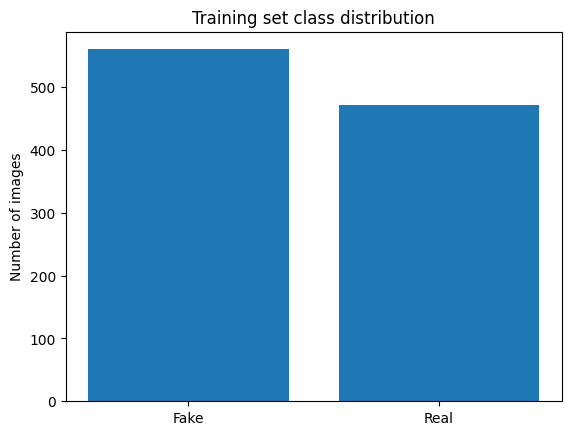

In [6]:
classes = ['Fake', 'Real']
train_counts = [len(fake_train), len(real_train)]

plt.bar(classes, train_counts)
plt.ylabel('Number of images')
plt.title('Training set class distribution')
plt.show()

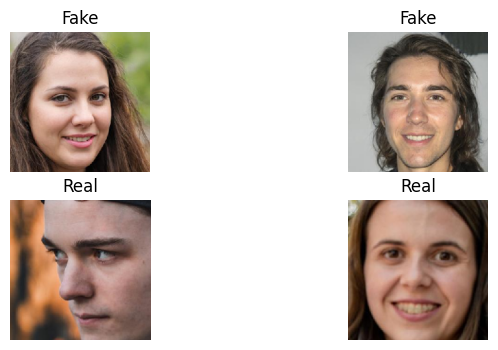

In [7]:
plt.figure(figsize=(8, 4))

# show 2 fake images
for i in range(2):
    img_path = os.path.join(train_dir, 'fake', random.choice(fake_train))
    img = image.load_img(img_path, target_size=(224, 224))
    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    plt.title('Fake')
    plt.axis('off')

# show 2 real images
for i in range(2):
    img_path = os.path.join(train_dir, 'real', random.choice(real_train))
    img = image.load_img(img_path, target_size=(224, 224))
    plt.subplot(2, 2, i + 3)
    plt.imshow(img)
    plt.title('Real')
    plt.axis('off')

plt.show()

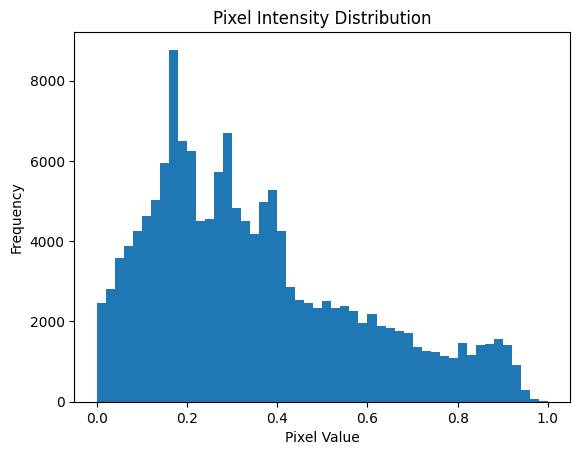

In [8]:
img = image.load_img(
    os.path.join(train_dir, 'fake', random.choice(fake_train)),
    target_size=(224,224)
)
img_array = image.img_to_array(img) / 255.0

plt.hist(img_array.flatten(), bins=50)
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()

# 4- Data Augmentation

## Data Augmentation Decision:
---------------------------
Use moderate augmentation on the training set only.
Validation and test must stay unchanged for fair evaluation
Faces can appear with small rotations or shifts
We want more variation without destroying fake/real artifacts

Augmentation Applied:
1. Rotation: ±15 degrees (faces can be slightly tilted)
2. Width/Height Shift: 10% (slight position variations)
3. Horizontal Flip: Yes (faces can be mirrored)
4. Zoom: 10% (different face sizes)
5. Fill Mode: Nearest (to avoid artifacts)

In [9]:
IMG_SIZE = 224
BATCH_SIZE = 32
N_SPLITS = 5

# Full paths and labels
all_train_files  = [os.path.join(train_dir, 'fake', f) for f in fake_train] + \
                   [os.path.join(train_dir, 'real', f) for f in real_train]
all_train_labels = [0]*len(fake_train) + [1]*len(real_train)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# 5- Transfer Learning Model RESNET50

In [10]:
def create_model(img_size=IMG_SIZE):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
    base_model.trainable = False
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.7),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# 6- K-Fold Training

In [11]:
kfold_df = pd.DataFrame({'filename': all_train_files, 'class': all_train_labels})
kfold_df['class'] = kfold_df['class'].map({0: 'fake', 1: 'real'})

# Map classes to integers for class_weight calculation
y_train_int = kfold_df['class'].map({'fake': 0, 'real': 1}).values

# Compute class weights
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_int),
    y=y_train_int
)
class_weights = dict(enumerate(weights))
print("Class weights:", class_weights)

Class weights: {0: np.float64(0.9205357142857142), 1: np.float64(1.09447983014862)}


K-FOLD CROSS-VALIDATION (Model Evaluation)

Evaluating model across 5 folds...

Fold 1/5... Found 824 validated image filenames belonging to 2 classes.
Found 207 validated image filenames belonging to 2 classes.


I0000 00:00:1766361933.479923      23 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1766361933.480606      23 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


I0000 00:00:1766361943.435075      69 service.cc:152] XLA service 0x7b5ccc003d20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766361943.435117      69 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1766361943.435122      69 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1766361945.231906      69 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1766361950.025131      69 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Val Acc: 0.7778
Fold 2/5... Found 825 validated image filenames belonging to 2 classes.
Found 206 validated image filenames belonging to 2 classes.
Val Acc: 0.7136
Fold 3/5... Found 825 validated image filenames belonging to 2 classes.
Found 206 validated image filenames belonging to 2 classes.
Val Acc: 0.7767
Fold 4/5... Found 825 validated image filenames belonging to 2 classes.
Found 206 validated image filenames belonging to 2 classes.
Val Acc: 0.7621
Fold 5/5... Found 825 validated image filenames belonging to 2 classes.
Found 206 validated image filenames belonging to 2 classes.
Val Acc: 0.7184

CROSS-VALIDATION RESULTS
Fold 1: 0.7778
Fold 2: 0.7136
Fold 3: 0.7767
Fold 4: 0.7621
Fold 5: 0.7184

Mean Accuracy: 0.7497
Std Deviation: 0.0281


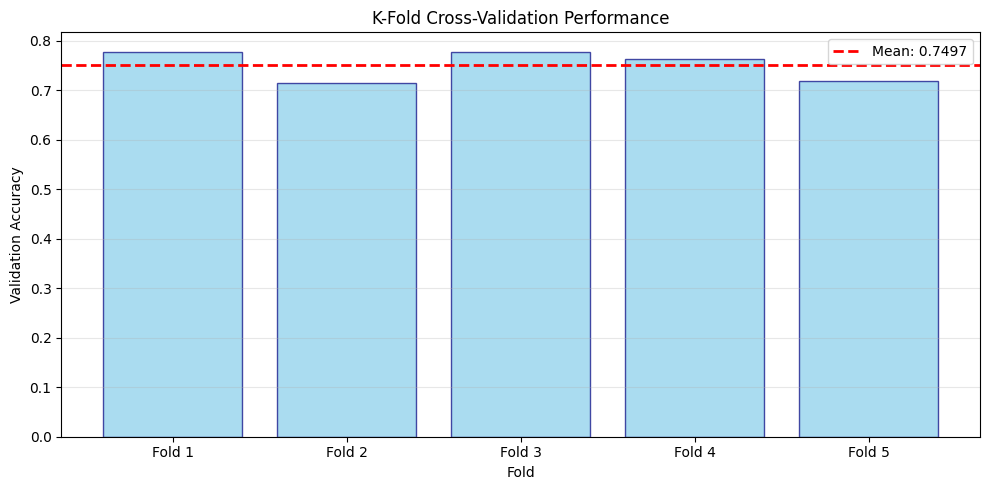

In [12]:
# ==============================
# STEP 6: K-Fold Cross-Validation (Performance Estimation)
# ==============================

print("="*60)
print("K-FOLD CROSS-VALIDATION (Model Evaluation)")
print("="*60)


skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

fold_accuracies = []

print("\nEvaluating model across 5 folds...\n")

for fold, (train_idx, val_idx) in enumerate(skf.split(kfold_df['filename'], kfold_df['class'])):
    print(f"Fold {fold+1}/{N_SPLITS}...", end=" ")
    
    # Create generators
    train_gen = train_datagen.flow_from_dataframe(
        kfold_df.iloc[train_idx], x_col='filename', y_col='class',
        target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, 
        class_mode='binary'
    )
    val_gen = valid_datagen.flow_from_dataframe(
        kfold_df.iloc[val_idx], x_col='filename', y_col='class',
        target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, 
        class_mode='binary', shuffle=False
    )
    
    # Train model
    model = create_model()
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    history = model.fit(
        train_gen, 
        validation_data=val_gen, 
        epochs=20,
        callbacks=[early_stop],
        verbose=0,
        class_weight=class_weights
    )
    
    acc = max(history.history['val_accuracy'])
    fold_accuracies.append(acc)
    print(f"Val Acc: {acc:.4f}")

# Results
mean_acc = np.mean(fold_accuracies)
std_acc = np.std(fold_accuracies)

print("\n" + "="*60)
print("CROSS-VALIDATION RESULTS")
for i, acc in enumerate(fold_accuracies):
    print(f"Fold {i+1}: {acc:.4f}")
print(f"\nMean Accuracy: {mean_acc:.4f}")
print(f"Std Deviation: {std_acc:.4f}")

# Visualize K-Fold results
plt.figure(figsize=(10, 5))
folds = [f"Fold {i+1}" for i in range(N_SPLITS)]
plt.bar(folds, fold_accuracies, color='skyblue', edgecolor='navy', alpha=0.7)
plt.axhline(mean_acc, color='red', linestyle='--', linewidth=2,
            label=f'Mean: {mean_acc:.4f}')
plt.xlabel('Fold')
plt.ylabel('Validation Accuracy')
plt.title('K-Fold Cross-Validation Performance')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

In [13]:
# Use the same N_SPLITS as before
n_splits = N_SPLITS  

# X can be filenames, y is the class labels
X = kfold_df['filename']
y = kfold_df['class']

# StratifiedKFold object
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

In [14]:
def plot_kfold(cv, X, y, ax, n_splits, xlim_max=100):
    """
    Plots the indices for a cross-validation object.

    Parameters:
    cv: Cross-validation object
    X: Feature set
    y: Target variable
    ax: Matplotlib axis object
    n_splits: Number of folds in the cross-validation
    xlim_max: Maximum limit for the x-axis
    """
    
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
    
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
        
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)

    y_ticks = np.arange(n_splits) + 0.5
    ax.set(yticks=y_ticks, yticklabels=range(n_splits),
           xlabel="Sample index", ylabel="Fold",
           ylim=[n_splits, -0.2], xlim=[0, xlim_max])

    ax.set_title("K-Fold Split Visualization", fontsize=14)
    legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"),
                      Patch(color=cmap_cv(0.02), label="Training set")]
    ax.legend(handles=legend_patches, loc=(1.03, 0.8))

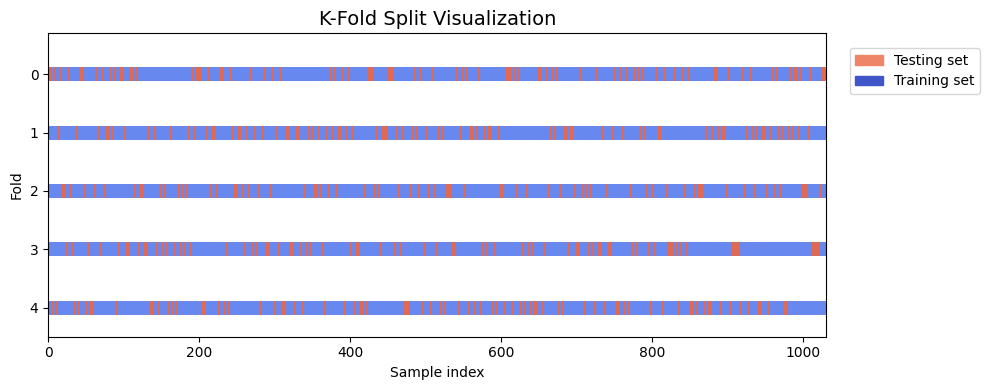

In [15]:
fig, ax = plt.subplots(figsize=(10, 4))
plot_kfold(cv, X, y, ax, n_splits, xlim_max=len(X))
plt.tight_layout()
plt.show()

In [16]:
# ==============================
# STEP 7: Final Model Training (Separate Split)
# ==============================

print("\n" + "="*60)
print("FINAL MODEL TRAINING")
print("="*60)
print("\nUsing separate train/validation split for model training")
print("and visualization of learning curves.\n")

# Create a fresh 80/20 split for final training
train_df, val_df = train_test_split(
    kfold_df, 
    test_size=0.2, 
    stratify=kfold_df['class'], 
    random_state=42
)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")

# Create generators
final_train_gen = train_datagen.flow_from_dataframe(
    train_df, x_col='filename', y_col='class',
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, 
    class_mode='binary'
)

final_val_gen = valid_datagen.flow_from_dataframe(
    val_df, x_col='filename', y_col='class',
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, 
    class_mode='binary', shuffle=False
)

# Phase 1: Feature Extraction
print("\nPhase 1: Feature Extraction (frozen base)...")
final_model = create_model()
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

history_phase1 = final_model.fit(
    final_train_gen,
    validation_data=final_val_gen,
    epochs=20,
    callbacks=[early_stop],
    class_weight=class_weights
)


FINAL MODEL TRAINING

Using separate train/validation split for model training
and visualization of learning curves.

Training samples: 824
Validation samples: 207
Found 824 validated image filenames belonging to 2 classes.
Found 207 validated image filenames belonging to 2 classes.

Phase 1: Feature Extraction (frozen base)...
Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 683ms/step - accuracy: 0.5089 - loss: 0.9863 - val_accuracy: 0.4589 - val_loss: 0.7163
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 352ms/step - accuracy: 0.4711 - loss: 0.9116 - val_accuracy: 0.5411 - val_loss: 0.6925
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 344ms/step - accuracy: 0.5398 - loss: 0.8005 - val_accuracy: 0.4589 - val_loss: 0.7007
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 351ms/step - accuracy: 0.4530 - loss: 0.8226 - val_accuracy: 0.4686 - val_loss: 0.6931
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 348ms/step - accuracy: 0.5072 - loss: 0.7238 - val_accuracy: 0.5411 - val_loss: 0.6870
Epoch 6/20
26/26 ━━━━━━━━━━━

In [17]:
# ==============================
# STEP 8: Fine-Tuning
# ==============================

print("\n" + "="*60)
print("FINE-TUNING")
print("="*60)

# Unfreeze last 15 layers
base_model = final_model.layers[0]
base_model.trainable = True
for layer in base_model.layers[:-15]:
    layer.trainable = False

trainable_count = sum([1 for layer in base_model.layers if layer.trainable])
print(f"Unfrozen layers: {trainable_count}/50")

# Recompile with lower learning rate
final_model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("\nPhase 2: Fine-tuning last 15 layers...")
history_phase2 = final_model.fit(
    final_train_gen,
    validation_data=final_val_gen,
    epochs=15,
    callbacks=[early_stop],
    class_weight=class_weights
)

# Save model
final_model.save("/kaggle/working/final_resnet50_model.keras")
print("\n✓ Model saved!")


FINE-TUNING
Unfrozen layers: 15/50

Phase 2: Fine-tuning last 15 layers...
Epoch 1/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 34s 773ms/step - accuracy: 0.5917 - loss: 0.6969 - val_accuracy: 0.5990 - val_loss: 0.6739
Epoch 2/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 360ms/step - accuracy: 0.7233 - loss: 0.6046 - val_accuracy: 0.6522 - val_loss: 0.6711
Epoch 3/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 354ms/step - accuracy: 0.7543 - loss: 0.5630 - val_accuracy: 0.7488 - val_loss: 0.6641
Epoch 4/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 355ms/step - accuracy: 0.7877 - loss: 0.5113 - val_accuracy: 0.6570 - val_loss: 0.6534
Epoch 5/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 351ms/step - accuracy: 0.8254 - loss: 0.4575 - val_accuracy: 0.5411 - val_loss: 0.6401
Epoch 6/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 360ms/step - accuracy: 0.8536 - loss: 0.4067 - val_accuracy: 0.5411 - val_loss: 0.6292
Epoch 7/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 353ms/step - accuracy: 0.8751 - loss: 0.3468 - val_accuracy: 0.5411 - val_loss: 0.6143
Epoch 8/15
26/26 ━━━━━━━━━━

In [18]:
# ============================================================
# ADD THIS AFTER CREATING FINAL MODEL (After Step 7)
# ============================================================

# Model Architecture Summary
print("\n" + "="*60)
print("MODEL ARCHITECTURE")
print("="*60)
final_model.summary()


MODEL ARCHITECTURE


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,415,685 (135.10 MB)

 Trainable params: 5,782,785 (22.06 MB)

 Non-trainable params: 18,067,328 (68.92 MB)

 Optimizer params: 11,565,572 (44.12 MB)

In [19]:
# Count parameters
total_params = final_model.count_params()
trainable_params = sum([tf.size(w).numpy() for w in final_model.trainable_weights])
non_trainable_params = total_params - trainable_params

print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Non-trainable parameters: {non_trainable_params:,}")


Total parameters: 23,850,113
Trainable parameters: 5,782,785
Non-trainable parameters: 18,067,328


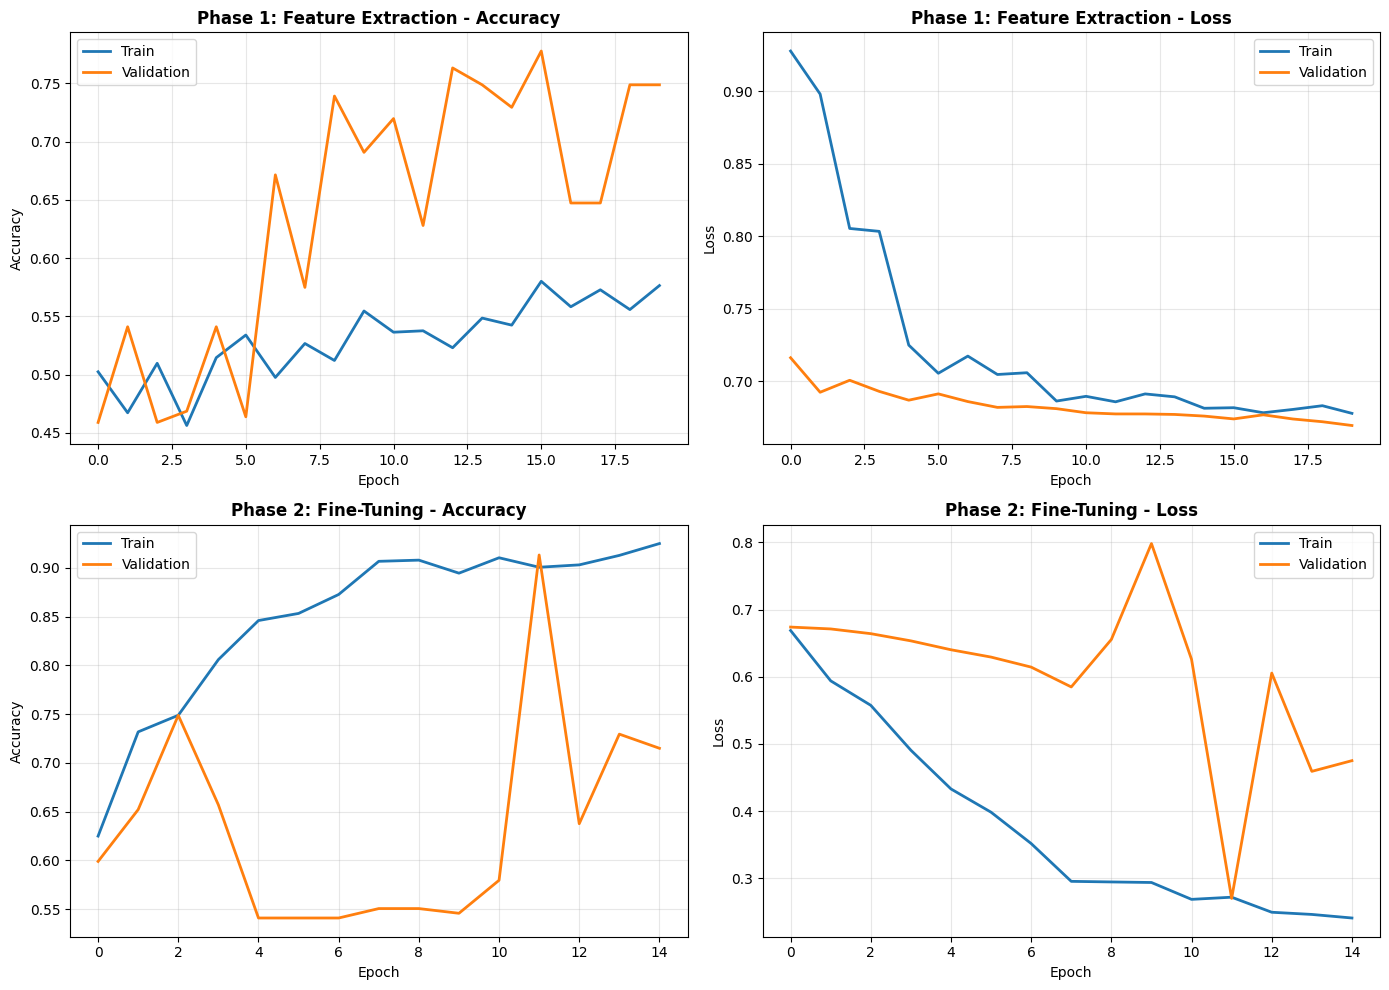


OVERFITTING ANALYSIS

Phase 1 (Feature Extraction):
  Train Accuracy: 0.5801
  Val Accuracy: 0.7778
  Gap: -0.1977

Phase 2 (Fine-Tuning):
  Train Accuracy: 0.9248
  Val Accuracy: 0.9130
  Gap: 0.0117

✓ Minimal overfitting - good generalization

SUMMARY
K-Fold CV Estimate: 0.7497 ± 0.0281
Final Model Val Acc: 0.9130


In [20]:
# ==============================
# STEP 9: Training Curves & Analysis
# ==============================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Phase 1 - Accuracy
axes[0, 0].plot(history_phase1.history['accuracy'], label='Train', linewidth=2)
axes[0, 0].plot(history_phase1.history['val_accuracy'], label='Validation', linewidth=2)
axes[0, 0].set_title('Phase 1: Feature Extraction - Accuracy', fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Phase 1 - Loss
axes[0, 1].plot(history_phase1.history['loss'], label='Train', linewidth=2)
axes[0, 1].plot(history_phase1.history['val_loss'], label='Validation', linewidth=2)
axes[0, 1].set_title('Phase 1: Feature Extraction - Loss', fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Phase 2 - Accuracy
axes[1, 0].plot(history_phase2.history['accuracy'], label='Train', linewidth=2)
axes[1, 0].plot(history_phase2.history['val_accuracy'], label='Validation', linewidth=2)
axes[1, 0].set_title('Phase 2: Fine-Tuning - Accuracy', fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Phase 2 - Loss
axes[1, 1].plot(history_phase2.history['loss'], label='Train', linewidth=2)
axes[1, 1].plot(history_phase2.history['val_loss'], label='Validation', linewidth=2)
axes[1, 1].set_title('Phase 2: Fine-Tuning - Loss', fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ==============================
# Overfitting Analysis
# ==============================

print("\n" + "="*60)
print("OVERFITTING ANALYSIS")
print("="*60)

phase1_train = max(history_phase1.history['accuracy'])
phase1_val = max(history_phase1.history['val_accuracy'])
phase1_gap = phase1_train - phase1_val

phase2_train = max(history_phase2.history['accuracy'])
phase2_val = max(history_phase2.history['val_accuracy'])
phase2_gap = phase2_train - phase2_val

print("\nPhase 1 (Feature Extraction):")
print(f"  Train Accuracy: {phase1_train:.4f}")
print(f"  Val Accuracy: {phase1_val:.4f}")
print(f"  Gap: {phase1_gap:.4f}")

print("\nPhase 2 (Fine-Tuning):")
print(f"  Train Accuracy: {phase2_train:.4f}")
print(f"  Val Accuracy: {phase2_val:.4f}")
print(f"  Gap: {phase2_gap:.4f}")

if phase2_gap < 0.05:
    print("\n✓ Minimal overfitting - good generalization")
elif phase2_gap < 0.10:
    print("\n⚠ Slight overfitting - acceptable")
else:
    print("\n✗ Significant overfitting detected")
    print("  Mitigated by: Dropout (0.7) + Early Stopping")

print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"K-Fold CV Estimate: {mean_acc:.4f} ± {std_acc:.4f}")
print(f"Final Model Val Acc: {phase2_val:.4f}")
print("="*60)

In [21]:
test_df = pd.DataFrame({
    'filename': [os.path.join(test_dir, 'fake', f) for f in fake_test] +
                [os.path.join(test_dir, 'real', f) for f in real_test],
    'class': [0]*len(fake_test) + [1]*len(real_test)
})

# Map classes to strings if using class_mode='binary'
test_df['class'] = test_df['class'].map({0: 'fake', 1: 'real'})


TEST SET EVALUATION
Found 258 validated image filenames belonging to 2 classes.
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 654ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 371ms/step
Best threshold: 0.3

Test Accuracy : 0.9651
Test Precision: 1.0000
Test Recall   : 0.9237
Test F1-score : 0.9604

Classification Report:
              precision    recall  f1-score   support

        Fake       0.94      1.00      0.97       140
        Real       1.00      0.92      0.96       118

    accuracy                           0.97       258
   macro avg       0.97      0.96      0.96       258
weighted avg       0.97      0.97      0.96       258



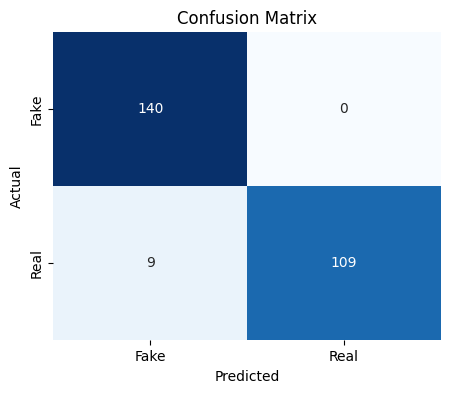

In [22]:
# ==============================
# STEP 10: TEST SET EVALUATION
# ==============================

print("\n" + "="*60)
print("TEST SET EVALUATION")
print("="*60)

# Make sure the test generator is properly set up
test_gen = valid_datagen.flow_from_dataframe(
    test_df,                # Your separate test dataframe
    x_col='filename',
    y_col='class',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False           # Critical to keep order aligned with y_true
)

# Reset generator to start
test_gen.reset()

# Predictions (probabilities)
y_pred_probs = final_model.predict(test_gen, steps=len(test_gen), verbose=1)

# Convert probabilities to class labels (binary)
from sklearn.metrics import f1_score

# Predict probabilities on validation set
val_probs = final_model.predict(final_val_gen)

thresholds = np.arange(0.3, 0.7, 0.01)
f1_scores = []

for t in thresholds:
    y_val_pred = (val_probs > t).astype(int)
    f1_scores.append(f1_score(final_val_gen.classes, y_val_pred))

best_thresh = thresholds[np.argmax(f1_scores)]
print("Best threshold:", best_thresh)

# Use this threshold on test set
y_pred = (y_pred_probs > best_thresh).astype(int).flatten()


# True labels
y_true = test_gen.classes

# ==============================
# Metrics
# ==============================
test_acc = accuracy_score(y_true, y_pred)
test_prec = precision_score(y_true, y_pred)
test_rec = recall_score(y_true, y_pred)
test_f1 = f1_score(y_true, y_pred)

print(f"\nTest Accuracy : {test_acc:.4f}")
print(f"Test Precision: {test_prec:.4f}")
print(f"Test Recall   : {test_rec:.4f}")
print(f"Test F1-score : {test_f1:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Fake','Real']))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Fake','Real'], yticklabels=['Fake','Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [23]:
print("Train class counts:", Counter(train_df['class']))
print("Validation class counts:", Counter(val_df['class']))
print("Test class counts:", Counter(test_df['class']))

Train class counts: Counter({'fake': 448, 'real': 376})
Validation class counts: Counter({'fake': 112, 'real': 95})
Test class counts: Counter({'fake': 140, 'real': 118})


In [24]:
# ============================================================
# HYPERPARAMETER EXPERIMENTS (OPTIMIZED VERSION)
# ============================================================
print("\n" + "="*60)
print("HYPERPARAMETER EXPERIMENTS")
print("="*60)

# Use a subset for faster experiments (30% of training data)
experiment_df = train_df.sample(frac=0.3, random_state=42)
exp_train, exp_val = train_test_split(
    experiment_df, test_size=0.2, stratify=experiment_df['class'], random_state=42
)


HYPERPARAMETER EXPERIMENTS



1. BATCH SIZE EFFECT
------------------------------------------------------------

Testing batch size: 16
Found 197 validated image filenames belonging to 2 classes.
Found 50 validated image filenames belonging to 2 classes.
  Validation Accuracy: 0.6000

Testing batch size: 32
Found 197 validated image filenames belonging to 2 classes.
Found 50 validated image filenames belonging to 2 classes.
  Validation Accuracy: 0.5600

Testing batch size: 64
Found 197 validated image filenames belonging to 2 classes.
Found 50 validated image filenames belonging to 2 classes.
  Validation Accuracy: 0.5600


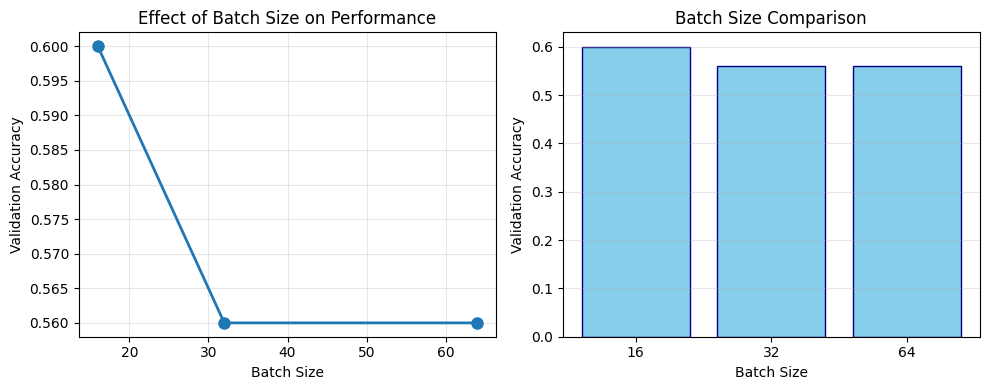

In [25]:
# ------------------------------------------------------------
# Experiment 1: Batch Size Effect
# ------------------------------------------------------------
print("\n1. BATCH SIZE EFFECT")
print("-" * 60)

batch_sizes = [16, 32, 64]
batch_results = []

for bs in batch_sizes:
    print(f"\nTesting batch size: {bs}")
    
    # Need different batch sizes, so we create new generators
    train_gen_exp = train_datagen.flow_from_dataframe(
        exp_train, x_col='filename', y_col='class',
        target_size=(IMG_SIZE, IMG_SIZE), batch_size=bs, class_mode='binary'
    )
    val_gen_exp = valid_datagen.flow_from_dataframe(
        exp_val, x_col='filename', y_col='class',
        target_size=(IMG_SIZE, IMG_SIZE), batch_size=bs, 
        class_mode='binary', shuffle=False
    )
    
    model = create_model()
    history = model.fit(
        train_gen_exp, validation_data=val_gen_exp, 
        epochs=10, verbose=0, class_weight=class_weights
    )
    
    val_acc = max(history.history['val_accuracy'])
    batch_results.append({'batch_size': bs, 'val_accuracy': val_acc})
    print(f"  Validation Accuracy: {val_acc:.4f}")

# Visualize
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot([r['batch_size'] for r in batch_results], 
         [r['val_accuracy'] for r in batch_results], 
         marker='o', linewidth=2, markersize=8)
plt.xlabel('Batch Size')
plt.ylabel('Validation Accuracy')
plt.title('Effect of Batch Size on Performance')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.bar([str(r['batch_size']) for r in batch_results],
        [r['val_accuracy'] for r in batch_results], 
        color='skyblue', edgecolor='navy')
plt.xlabel('Batch Size')
plt.ylabel('Validation Accuracy')
plt.title('Batch Size Comparison')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

In [26]:
# Create generators ONCE with batch_size=32
train_gen_exp = train_datagen.flow_from_dataframe(
    exp_train, x_col='filename', y_col='class',
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=32, class_mode='binary'
)
val_gen_exp = valid_datagen.flow_from_dataframe(
    exp_val, x_col='filename', y_col='class',
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=32, 
    class_mode='binary', shuffle=False
)

Found 197 validated image filenames belonging to 2 classes.
Found 50 validated image filenames belonging to 2 classes.



2. EARLY STOPPING EFFECT
------------------------------------------------------------

Training WITHOUT early stopping...
Training WITH early stopping (patience=5)...


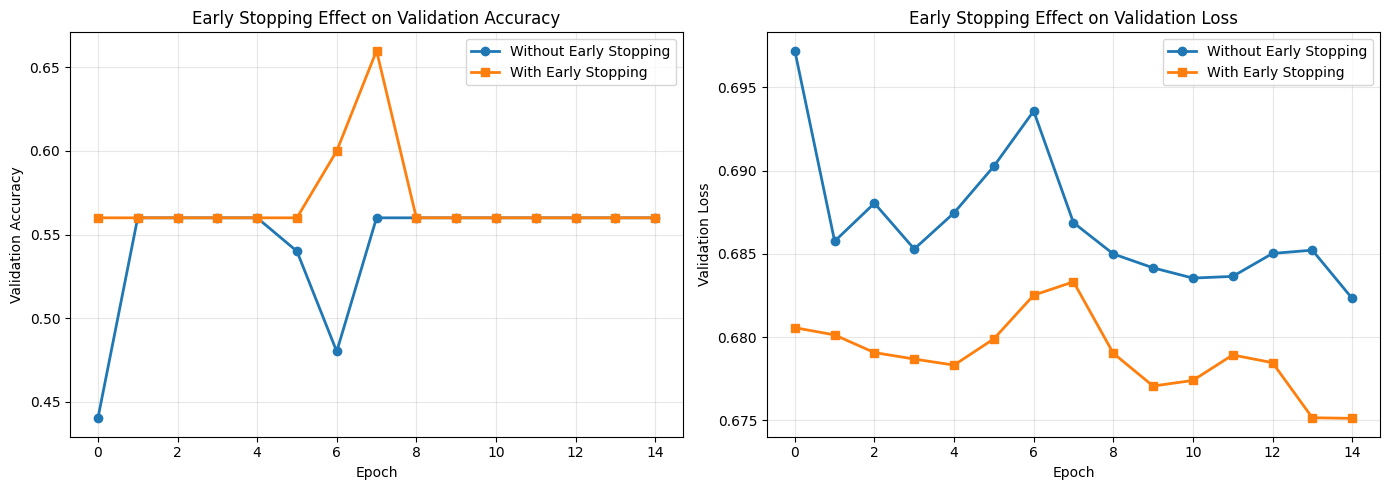


Without ES: Final Val Acc = 0.5600
With ES: Best Val Acc = 0.6600
With ES: Stopped at epoch 15


In [27]:
# ------------------------------------------------------------
# Experiment 2: Early Stopping Effect
# ------------------------------------------------------------
print("\n2. EARLY STOPPING EFFECT")
print("-" * 60)

# Without early stopping
print("\nTraining WITHOUT early stopping...")
train_gen_exp.reset()
val_gen_exp.reset()
model_no_es = create_model()
history_no_es = model_no_es.fit(
    train_gen_exp, validation_data=val_gen_exp, 
    epochs=15, verbose=0, class_weight=class_weights
)

# With early stopping
print("Training WITH early stopping (patience=5)...")
train_gen_exp.reset()  # Reset to start over
val_gen_exp.reset()
model_with_es = create_model()
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history_with_es = model_with_es.fit(
    train_gen_exp, validation_data=val_gen_exp, 
    epochs=15, callbacks=[early_stop], verbose=0, class_weight=class_weights
)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history_no_es.history['val_accuracy'], 
             label='Without Early Stopping', linewidth=2, marker='o')
axes[0].plot(history_with_es.history['val_accuracy'], 
             label='With Early Stopping', linewidth=2, marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Validation Accuracy')
axes[0].set_title('Early Stopping Effect on Validation Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history_no_es.history['val_loss'], 
             label='Without Early Stopping', linewidth=2, marker='o')
axes[1].plot(history_with_es.history['val_loss'], 
             label='With Early Stopping', linewidth=2, marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Validation Loss')
axes[1].set_title('Early Stopping Effect on Validation Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nWithout ES: Final Val Acc = {history_no_es.history['val_accuracy'][-1]:.4f}")
print(f"With ES: Best Val Acc = {max(history_with_es.history['val_accuracy']):.4f}")
print(f"With ES: Stopped at epoch {len(history_with_es.history['accuracy'])}")


3. LEARNING RATE EFFECT
------------------------------------------------------------

Testing learning rate: 0.01
  Best Validation Accuracy: 0.5600

Testing learning rate: 0.001
  Best Validation Accuracy: 0.7600

Testing learning rate: 0.0001
  Best Validation Accuracy: 0.5600


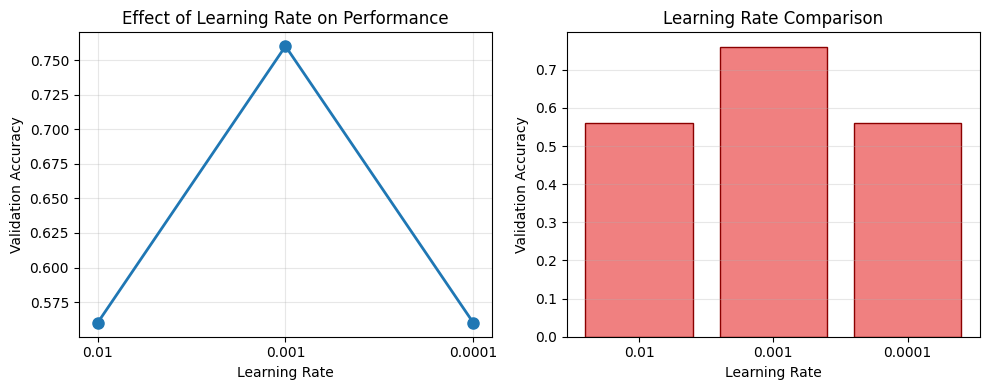

In [28]:
# ------------------------------------------------------------
# Experiment 3: Learning Rate Effect
# ------------------------------------------------------------
print("\n3. LEARNING RATE EFFECT")
print("-" * 60)

learning_rates = [0.01, 0.001, 0.0001]
lr_results = []

for lr in learning_rates:
    print(f"\nTesting learning rate: {lr}")
    
    # Create model with specific LR
    base_model = ResNet50(weights='imagenet', include_top=False, 
                          input_shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model.trainable = False
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.7),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    # Reset and train
    train_gen_exp.reset()
    val_gen_exp.reset()
    
    history = model.fit(
        train_gen_exp, validation_data=val_gen_exp, 
        epochs=10, verbose=0, class_weight=class_weights
    )
    
    val_acc = max(history.history['val_accuracy'])
    lr_results.append({'learning_rate': lr, 'val_accuracy': val_acc})
    print(f"  Best Validation Accuracy: {val_acc:.4f}")

# Visualize
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot([str(r['learning_rate']) for r in lr_results],
         [r['val_accuracy'] for r in lr_results], 
         marker='o', linewidth=2, markersize=8)
plt.xlabel('Learning Rate')
plt.ylabel('Validation Accuracy')
plt.title('Effect of Learning Rate on Performance')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.bar([str(r['learning_rate']) for r in lr_results],
        [r['val_accuracy'] for r in lr_results], 
        color='lightcoral', edgecolor='darkred')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Accuracy')
plt.title('Learning Rate Comparison')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


4. NUMBER OF EPOCHS EFFECT
------------------------------------------------------------


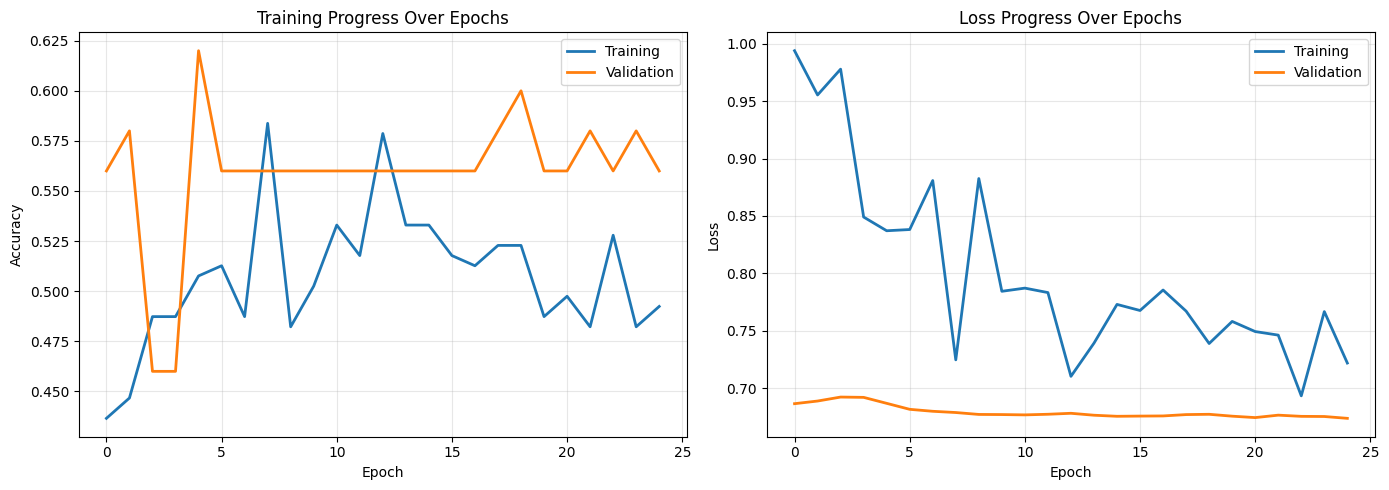


Best validation accuracy: 0.6200 at epoch 5
Training beyond epoch 5 may lead to overfitting


In [29]:

# ------------------------------------------------------------
# Experiment 4: Number of Epochs Effect
# ------------------------------------------------------------
print("\n4. NUMBER OF EPOCHS EFFECT")
print("-" * 60)

train_gen_exp.reset()
val_gen_exp.reset()

model = create_model()
history_epochs = model.fit(
    train_gen_exp, validation_data=val_gen_exp, 
    epochs=25, verbose=0, class_weight=class_weights
)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history_epochs.history['accuracy'], 
             label='Training', linewidth=2)
axes[0].plot(history_epochs.history['val_accuracy'], 
             label='Validation', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Training Progress Over Epochs')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history_epochs.history['loss'], 
             label='Training', linewidth=2)
axes[1].plot(history_epochs.history['val_loss'], 
             label='Validation', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Loss Progress Over Epochs')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

best_epoch = np.argmax(history_epochs.history['val_accuracy']) + 1
best_val_acc = max(history_epochs.history['val_accuracy'])

print(f"\nBest validation accuracy: {best_val_acc:.4f} at epoch {best_epoch}")
print(f"Training beyond epoch {best_epoch} may lead to overfitting")

In [30]:
# ------------------------------------------------------------
# Summary
# ------------------------------------------------------------
print("\n" + "="*60)
print("HYPERPARAMETER EXPERIMENT SUMMARY")
print("="*60)
print(f"Best Batch Size: {max(batch_results, key=lambda x: x['val_accuracy'])['batch_size']}")
print(f"Early Stopping: Recommended (improves generalization)")
print(f"Best Learning Rate: {max(lr_results, key=lambda x: x['val_accuracy'])['learning_rate']}")
print(f"Optimal Epochs: ~{best_epoch} epochs")
print("="*60)


HYPERPARAMETER EXPERIMENT SUMMARY
Best Batch Size: 16
Early Stopping: Recommended (improves generalization)
Best Learning Rate: 0.001
Optimal Epochs: ~5 epochs



BONUS: TESTING ENHANCED ARCHITECTURE

--- Original Architecture ---


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_15     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)


--- Enhanced Architecture (with bonus layers) ---


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_16     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,155,009 (92.14 MB)

 Trainable params: 566,529 (2.16 MB)

 Non-trainable params: 23,588,480 (89.98 MB)


TRAINING COMPARISON
Found 264 validated image filenames belonging to 2 classes.
Found 66 validated image filenames belonging to 2 classes.

1. Training ORIGINAL model...
Epoch 1/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.5067 - loss: 0.9167 - val_accuracy: 0.5455 - val_loss: 0.6903
Epoch 2/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 314ms/step - accuracy: 0.4743 - loss: 0.9516 - val_accuracy: 0.5606 - val_loss: 0.6904
Epoch 3/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 333ms/step - accuracy: 0.5244 - loss: 0.8393 - val_accuracy: 0.5455 - val_loss: 0.6892
Epoch 4/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 321ms/step - accuracy: 0.5225 - loss: 0.8620 - val_accuracy: 0.5455 - val_loss: 0.6862
Epoch 5/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 322ms/step - accuracy: 0.4713 - loss: 0.8340 - val_accuracy: 0.5455 - val_loss: 0.6870
Epoch 6/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 313ms/step - accuracy: 0.5400 - loss: 0.8066 - val_accuracy: 0.5455 - val_loss: 0.6864
Epoch 7/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 317ms/step - accuracy: 0.5090 - loss

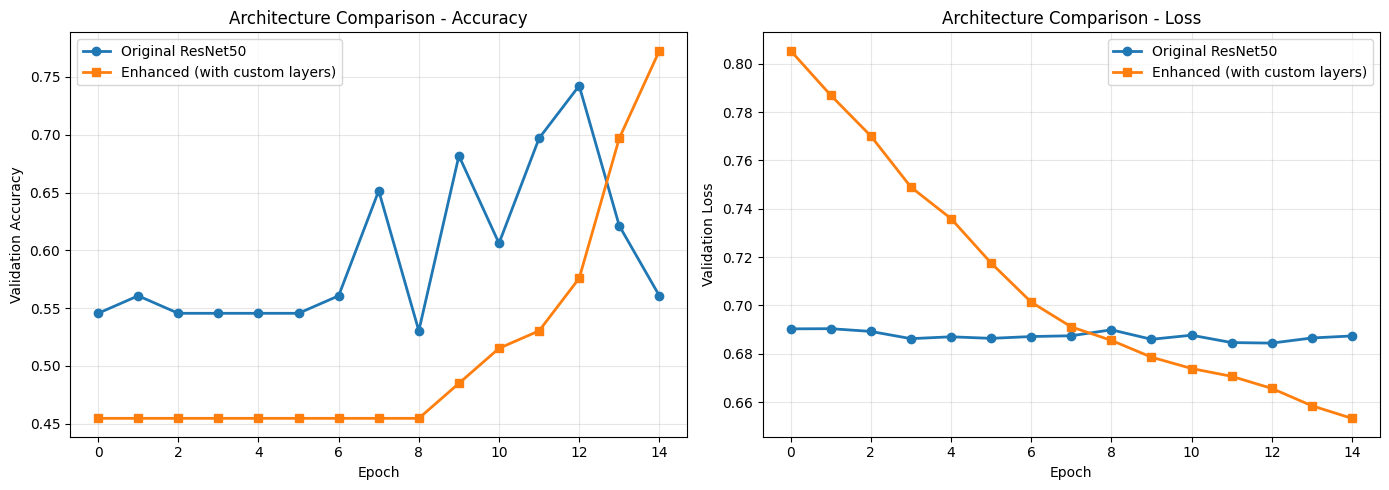


BONUS COMPARISON RESULTS
Original Model - Best Val Acc: 0.7424
Enhanced Model - Best Val Acc: 0.7727

Improvement: +3.03%
✓ Enhanced architecture shows improvement!

Enhancements made:
  • Added BatchNormalization layers for stable training
  • Increased first Dense layer to 256 units
  • Added extra Dense layer (64 units) for finer feature learning
  • Adjusted dropout rates for better regularization


In [31]:
# ============================================================
# BONUS: ENHANCED RESNET50 WITH CUSTOM LAYERS
# ============================================================

print("\n" + "="*60)
print("BONUS: TESTING ENHANCED ARCHITECTURE")
print("="*60)

# Your original model
def create_model_original(img_size=IMG_SIZE):
    base_model = ResNet50(weights='imagenet', include_top=False, 
                          input_shape=(img_size, img_size, 3))
    base_model.trainable = False
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.7),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Enhanced model with additional layers
def create_model_enhanced(img_size=IMG_SIZE):
    base_model = ResNet50(weights='imagenet', include_top=False, 
                          input_shape=(img_size, img_size, 3))
    base_model.trainable = False
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        
        # BONUS: Additional layers for better feature learning
        layers.Dense(256, activation='relu'),        # ← NEW: Larger first layer
        layers.BatchNormalization(),                 # ← NEW: Batch normalization
        layers.Dropout(0.5),
        
        layers.Dense(128, activation='relu'),        # ← Existing
        layers.BatchNormalization(),                 # ← NEW: Batch normalization
        layers.Dropout(0.5),
        
        layers.Dense(64, activation='relu'),         # ← NEW: Additional layer
        layers.Dropout(0.3),                         # ← NEW: Light dropout
        
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Compare architectures
print("\n--- Original Architecture ---")
original = create_model_original()
original.summary()

print("\n--- Enhanced Architecture (with bonus layers) ---")
enhanced = create_model_enhanced()
enhanced.summary()

# ============================================================
# Train Both Models and Compare
# ============================================================

print("\n" + "="*60)
print("TRAINING COMPARISON")
print("="*60)

# Use a subset for quick comparison
comparison_df = train_df.sample(frac=0.4, random_state=42)
comp_train, comp_val = train_test_split(
    comparison_df, test_size=0.2, stratify=comparison_df['class'], random_state=42
)

comp_train_gen = train_datagen.flow_from_dataframe(
    comp_train, x_col='filename', y_col='class',
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='binary'
)
comp_val_gen = valid_datagen.flow_from_dataframe(
    comp_val, x_col='filename', y_col='class',
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, 
    class_mode='binary', shuffle=False
)

# Train original
print("\n1. Training ORIGINAL model...")
comp_train_gen.reset()
comp_val_gen.reset()
model_orig = create_model_original()
history_orig = model_orig.fit(
    comp_train_gen, validation_data=comp_val_gen,
    epochs=15, verbose=1, class_weight=class_weights
)

# Train enhanced
print("\n2. Training ENHANCED model...")
comp_train_gen.reset()
comp_val_gen.reset()
model_enh = create_model_enhanced()
history_enh = model_enh.fit(
    comp_train_gen, validation_data=comp_val_gen,
    epochs=15, verbose=1, class_weight=class_weights
)

# ============================================================
# Visualize Comparison
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
axes[0].plot(history_orig.history['val_accuracy'], 
             label='Original ResNet50', linewidth=2, marker='o')
axes[0].plot(history_enh.history['val_accuracy'], 
             label='Enhanced (with custom layers)', linewidth=2, marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Validation Accuracy')
axes[0].set_title('Architecture Comparison - Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss comparison
axes[1].plot(history_orig.history['val_loss'], 
             label='Original ResNet50', linewidth=2, marker='o')
axes[1].plot(history_enh.history['val_loss'], 
             label='Enhanced (with custom layers)', linewidth=2, marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Validation Loss')
axes[1].set_title('Architecture Comparison - Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Results summary
print("\n" + "="*60)
print("BONUS COMPARISON RESULTS")
print("="*60)
print(f"Original Model - Best Val Acc: {max(history_orig.history['val_accuracy']):.4f}")
print(f"Enhanced Model - Best Val Acc: {max(history_enh.history['val_accuracy']):.4f}")

improvement = max(history_enh.history['val_accuracy']) - max(history_orig.history['val_accuracy'])
print(f"\nImprovement: {improvement*100:+.2f}%")

if improvement > 0:
    print("✓ Enhanced architecture shows improvement!")
else:
    print("⚠ Similar performance - both architectures work well")

print("\nEnhancements made:")
print("  • Added BatchNormalization layers for stable training")
print("  • Increased first Dense layer to 256 units")
print("  • Added extra Dense layer (64 units) for finer feature learning")
print("  • Adjusted dropout rates for better regularization")


BONUS: ENSEMBLE ARCHITECTURE (ResNet50 + MobileNetV2)

Preparing data for comparison...
Comparison set: 264 train, 66 val
Found 264 validated image filenames belonging to 2 classes.
Found 66 validated image filenames belonging to 2 classes.
Found 264 validated image filenames belonging to 2 classes.
Found 66 validated image filenames belonging to 2 classes.

TRAINING COMPARISON

1. Training ResNet50...
Epoch 1/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.5154 - loss: 0.8577 - val_accuracy: 0.5455 - val_loss: 0.6886
Epoch 2/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 319ms/step - accuracy: 0.4859 - loss: 0.8402 - val_accuracy: 0.4545 - val_loss: 0.6904
Epoch 3/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 316ms/step - accuracy: 0.5602 - loss: 0.7448 - val_accuracy: 0.6061 - val_loss: 0.6849
Epoch 4/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 326ms/step - accuracy: 0.4560 - loss: 0.9225 - val_accuracy: 0.5606 - val_loss: 0.6829
Epoch 5/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 320ms/step - accuracy: 0.5452 - loss: 0.7675 - val_a

2025-12-22 00:39:55.904109: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-22 00:39:56.041719: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1/9 ━━━━━━━━━━━━━━━━━━━━ 2:03 15s/step - accuracy: 0.4375 - loss: 1.0840

2025-12-22 00:40:05.697605: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-22 00:40:05.834502: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4786 - loss: 1.0080

2025-12-22 00:40:20.719266: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-22 00:40:20.855478: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


9/9 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.4811 - loss: 1.0030 - val_accuracy: 0.6818 - val_loss: 0.6240
Epoch 2/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 294ms/step - accuracy: 0.5743 - loss: 0.9075 - val_accuracy: 0.7576 - val_loss: 0.5439
Epoch 3/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 303ms/step - accuracy: 0.6322 - loss: 0.6983 - val_accuracy: 0.8636 - val_loss: 0.4500
Epoch 4/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 300ms/step - accuracy: 0.6732 - loss: 0.5974 - val_accuracy: 0.9091 - val_loss: 0.3824
Epoch 5/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 302ms/step - accuracy: 0.8154 - loss: 0.4192 - val_accuracy: 0.9242 - val_loss: 0.3352
Epoch 6/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 303ms/step - accuracy: 0.7902 - loss: 0.4279 - val_accuracy: 0.9091 - val_loss: 0.3076
Epoch 7/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 291ms/step - accuracy: 0.8160 - loss: 0.3940 - val_accuracy: 0.9242 - val_loss: 0.2788
Epoch 8/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 299ms/step - accuracy: 0.8645 - loss: 0.3145 - val_accuracy: 0.9394 - val_loss: 0.2519
Epoch

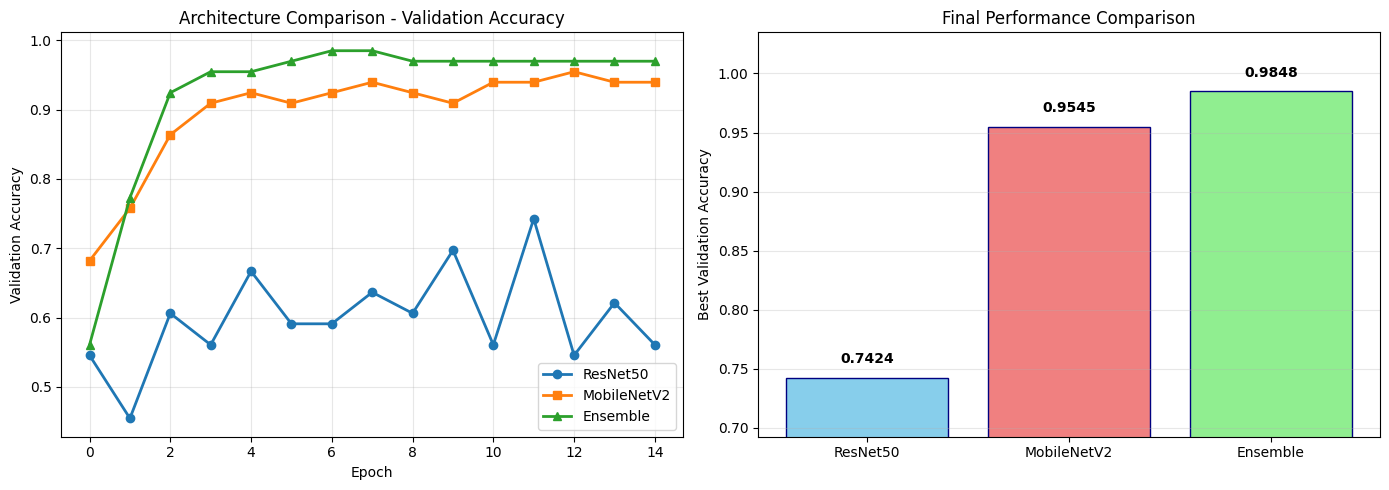


BONUS ENSEMBLE RESULTS
ResNet50       : 0.7424
MobileNetV2    : 0.9545
Ensemble       : 0.9848

Best Model: Ensemble (0.9848)
Ensemble Improvement: +3.03%

Key Points:
  • ResNet50 and MobileNetV2 use DIFFERENT preprocessing
  • Ensemble applies correct preprocessing to each branch
  • Both branches learn complementary features
  • Final decision combines both architectures


In [32]:
# ============================================================
# BONUS: ENSEMBLE OF RESNET50 + MOBILENETV2 (CORRECT VERSION)
# ============================================================

print("\n" + "="*60)
print("BONUS: ENSEMBLE ARCHITECTURE (ResNet50 + MobileNetV2)")
print("="*60)

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Concatenate, Lambda
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess

# ============================================================
# INDIVIDUAL MODELS (for comparison)
# ============================================================

def create_resnet_model(img_size=IMG_SIZE):
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(img_size, img_size, 3)
    )
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.7),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


def create_mobilenet_model(img_size=IMG_SIZE):
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(img_size, img_size, 3)
    )
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.7),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


# ============================================================
# ENSEMBLE MODEL (CORRECT PREPROCESSING PER BRANCH)
# ============================================================

def create_ensemble_model(img_size=IMG_SIZE):
    """
    Ensemble model combining ResNet50 and MobileNetV2.
    Each branch applies its own proper preprocessing.
    """
    # Input expects raw pixels [0, 255] from generator
    input_layer = Input(shape=(img_size, img_size, 3))

    # -------- ResNet50 branch --------
    resnet_input = Lambda(resnet_preprocess)(input_layer)
    resnet_base = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(img_size, img_size, 3)
    )
    resnet_base.trainable = False

    resnet_branch = resnet_base(resnet_input)
    resnet_branch = layers.GlobalAveragePooling2D()(resnet_branch)
    resnet_branch = layers.Dense(64, activation='relu')(resnet_branch)

    # -------- MobileNetV2 branch --------
    mobilenet_input = Lambda(mobilenet_preprocess)(input_layer)
    mobilenet_base = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(img_size, img_size, 3)
    )
    mobilenet_base.trainable = False

    mobilenet_branch = mobilenet_base(mobilenet_input)
    mobilenet_branch = layers.GlobalAveragePooling2D()(mobilenet_branch)
    mobilenet_branch = layers.Dense(64, activation='relu')(mobilenet_branch)

    # -------- Combine branches --------
    combined = Concatenate()([resnet_branch, mobilenet_branch])
    combined = layers.Dense(128, activation='relu')(combined)
    combined = layers.Dropout(0.5)(combined)
    combined = layers.Dense(64, activation='relu')(combined)
    combined = layers.Dropout(0.3)(combined)

    output = layers.Dense(1, activation='sigmoid')(combined)

    model = Model(inputs=input_layer, outputs=output)

    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


# ============================================================
# DATA SPLIT FOR COMPARISON
# ============================================================

print("\nPreparing data for comparison...")
comparison_df = train_df.sample(frac=0.4, random_state=42)

comp_train, comp_val = train_test_split(
    comparison_df,
    test_size=0.2,
    stratify=comparison_df['class'],
    random_state=42
)

print(f"Comparison set: {len(comp_train)} train, {len(comp_val)} val")

# ============================================================
# GENERATORS FOR SINGLE MODELS (WITH RESCALING)
# ============================================================

# These use rescale=1./255 (your existing train_datagen/valid_datagen)
comp_train_gen = train_datagen.flow_from_dataframe(
    comp_train,
    x_col='filename',
    y_col='class',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

comp_val_gen = valid_datagen.flow_from_dataframe(
    comp_val,
    x_col='filename',
    y_col='class',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# ============================================================
# ENSEMBLE-ONLY GENERATORS (NO RESCALING - RAW PIXELS)
# ============================================================

# Ensemble needs raw pixels [0, 255] for proper preprocessing
ensemble_train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
    # NO rescale parameter!
)

ensemble_val_datagen = ImageDataGenerator()  # No augmentation for validation

ensemble_train_gen = ensemble_train_datagen.flow_from_dataframe(
    comp_train,
    x_col='filename',
    y_col='class',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

ensemble_val_gen = ensemble_val_datagen.flow_from_dataframe(
    comp_val,
    x_col='filename',
    y_col='class',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# ============================================================
# TRAIN ALL MODELS
# ============================================================

print("\n" + "="*60)
print("TRAINING COMPARISON")
print("="*60)

results = {}

print("\n1. Training ResNet50...")
comp_train_gen.reset()
comp_val_gen.reset()
model_resnet = create_resnet_model()
history_resnet = model_resnet.fit(
    comp_train_gen,
    validation_data=comp_val_gen,
    epochs=15,
    verbose=1,
    class_weight=class_weights
)
results['ResNet50'] = max(history_resnet.history['val_accuracy'])
print(f"   Best Val Acc: {results['ResNet50']:.4f}")

print("\n2. Training MobileNetV2...")
comp_train_gen.reset()
comp_val_gen.reset()
model_mobile = create_mobilenet_model()
history_mobile = model_mobile.fit(
    comp_train_gen,
    validation_data=comp_val_gen,
    epochs=15,
    verbose=1,
    class_weight=class_weights
)
results['MobileNetV2'] = max(history_mobile.history['val_accuracy'])
print(f"   Best Val Acc: {results['MobileNetV2']:.4f}")

print("\n3. Training Ensemble (ResNet50 + MobileNetV2)...")
ensemble_train_gen.reset()
ensemble_val_gen.reset()
model_ensemble = create_ensemble_model()
history_ensemble = model_ensemble.fit(
    ensemble_train_gen,
    validation_data=ensemble_val_gen,
    epochs=15,
    verbose=1,
    class_weight=class_weights
)
results['Ensemble'] = max(history_ensemble.history['val_accuracy'])
print(f"   Best Val Acc: {results['Ensemble']:.4f}")

# ============================================================
# VISUALIZE COMPARISON
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Validation accuracy curves
axes[0].plot(history_resnet.history['val_accuracy'], 
             label='ResNet50', linewidth=2, marker='o')
axes[0].plot(history_mobile.history['val_accuracy'], 
             label='MobileNetV2', linewidth=2, marker='s')
axes[0].plot(history_ensemble.history['val_accuracy'], 
             label='Ensemble', linewidth=2, marker='^')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Validation Accuracy')
axes[0].set_title('Architecture Comparison - Validation Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Bar chart comparison
axes[1].bar(results.keys(), results.values(), 
            color=['skyblue', 'lightcoral', 'lightgreen'],
            edgecolor='navy')
axes[1].set_ylabel('Best Validation Accuracy')
axes[1].set_title('Final Performance Comparison')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_ylim([min(results.values())-0.05, max(results.values())+0.05])

# Add value labels on bars
for i, (name, val) in enumerate(results.items()):
    axes[1].text(i, val + 0.01, f'{val:.4f}', 
                ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# ============================================================
# RESULTS SUMMARY
# ============================================================

print("\n" + "="*60)
print("BONUS ENSEMBLE RESULTS")
print("="*60)

for name, acc in results.items():
    print(f"{name:15s}: {acc:.4f}")

best_model = max(results, key=results.get)
print(f"\nBest Model: {best_model} ({results[best_model]:.4f})")

improvement = results['Ensemble'] - max(results['ResNet50'], results['MobileNetV2'])
print(f"Ensemble Improvement: {improvement*100:+.2f}%")

print("\nKey Points:")
print("  • ResNet50 and MobileNetV2 use DIFFERENT preprocessing")
print("  • Ensemble applies correct preprocessing to each branch")
print("  • Both branches learn complementary features")
print("  • Final decision combines both architectures")
print("="*60)